# A quick look at the depth-age relationship for the seafloor.

We have two problems: the resolution of the two datasets is not equal and so it will be difficult to sample points one-to-one for the purposes of plotting a graph. The other problem is that we have uniformly spaced data in a latitude and longitude grid. This means that the area represented by each grid point or grid square is very different depending on how close to the pole you are. This is something that we encounter
all the time when working with map projections

<div>
<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/7/73/Mercator_projection_Square.JPG/700px-Mercator_projection_Square.JPG" width=30%>

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/0/02/Mercator_with_Tissot%27s_Indicatrices_of_Distortion.svg/700px-Mercator_with_Tissot%27s_Indicatrices_of_Distortion.svg.png" width=30%>
</div>

In these images you can see on the left, how the area in a mercator projection is horribly distorted near the poles and this is quantified on the right by showing the area represented by a small region in the projected space (from https://en.wikipedia.org/wiki/Mercator_projection)

Here is an example of a grid that is uniform on the sphere: 

<div>
<img src="./Images/Icosahedron.png" width=40%>
</div>

We have a library `stripy` that can generate points for uniform triangulations but somehow we will need to interpolate our data.

## Let's try the triangulation routines and map the points

This is how we make a mesh in `stripy`

In [1]:
import stripy
import numpy as np

even_mesh = stripy.spherical_meshes.icosahedral_mesh(include_face_points=True, tree=True, refinement_levels=4)
number_of_mesh_points = even_mesh.npoints

latitudes_in_radians = even_mesh.lats
latitudes_in_degrees = np.degrees(latitudes_in_radians) 

longitudes_in_radians = even_mesh.lons 
longitudes_in_degrees = np.degrees(longitudes_in_radians)%360.0 - 180.0

## Have a look

Here we plot the points on the globe to demonstrate that the points are evenly spaced. 

Exercise: 

  1. Try changing the `refinement_levels` parameter from 2 to 4 
  2. Can you make a plot that demonstrates the uneven spacing of the points in a regular spaced grid 
     (Hint: *there are two ways - one is to create a regular grid of points and plot those in this projection. The other might be to 
     plot the regular points on a flat projection. You can choose*)

/usr/share/miniconda3/envs/jupyter/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:388: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  inframe=inframe)


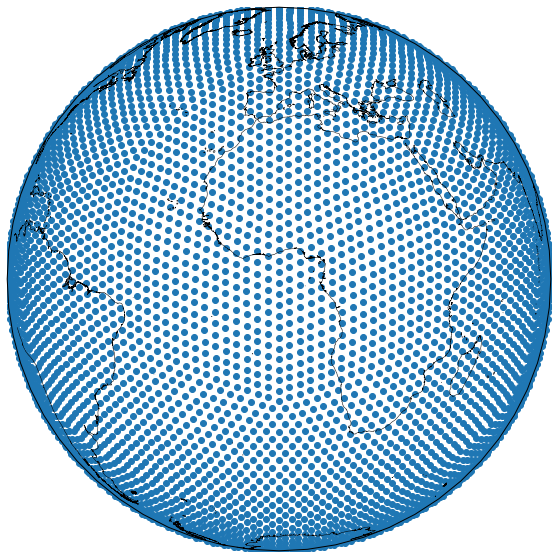

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

import cartopy.crs as ccrs
import cartopy.feature as cfeature

coastline = cfeature.NaturalEarthFeature('physical', 'coastline', '10m',
                           edgecolor=(1.0,0.8,0.0),
                           facecolor="none")

plt.figure(figsize=(15, 10))
ax = plt.subplot(111, projection=ccrs.Orthographic(central_longitude=0.1))

ax.add_feature(coastline, edgecolor="black", linewidth=0.5, zorder=3)

plt.scatter(longitudes_in_degrees, latitudes_in_degrees, transform=ccrs.PlateCarree())

## Find the age or depth values on these points 

Now we would like to interpolate each of our datasets to the same set of grid points. That way we can plot them against each other correctly.
Let us do this with the age grid to begin with.

In [3]:
import xarray

age_dataset = "../Data/age.3.6.nc"
age_data = xarray.open_dataset(age_dataset)
subs_data = age_data.sel(x=slice(-180,180, 1), y=slice(-90, 90, 1))

lons = subs_data.coords.get('x')
lats = subs_data.coords.get('y')
vals = subs_data['z']

x,y = np.meshgrid(lons.data, lats.data)
age = vals.data / 100.0

age[np.isnan(age)] = -1.0

In [4]:
def map_raster_to_mesh(mesh, latlongrid):
    
    raster = latlongrid.T

    latitudes_in_radians  = mesh.lats
    longitudes_in_radians = mesh.lons 
    latitudes_in_degrees  = np.degrees(latitudes_in_radians) 
    longitudes_in_degrees = np.degrees(longitudes_in_radians)%360.0 - 180.0

    dlons = np.mod(longitudes_in_degrees+180.0, 360.0)
    dlats = np.mod(latitudes_in_degrees+90, 180.0)

    ilons = raster.shape[0] * dlons / 360.0
    ilats = raster.shape[1] * dlats / 180.0

    icoords = np.array((ilons, ilats))

    from scipy import ndimage

    mvals = ndimage.map_coordinates(raster, icoords , order=3, mode='nearest').astype(np.float)
    
    return mvals

meshages = map_raster_to_mesh(even_mesh, age)

/usr/share/miniconda3/envs/jupyter/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


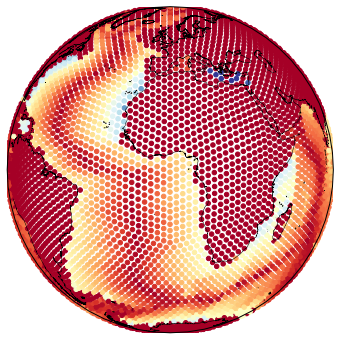

In [5]:
plt.figure(figsize=(6, 6))
ax = plt.subplot(111, projection=ccrs.Orthographic(central_longitude=0.1))

ax.add_feature(coastline, edgecolor="black", linewidth=0.5, zorder=3)

plt.scatter(longitudes_in_degrees, latitudes_in_degrees, c=meshages, cmap="RdYlBu",
            vmin=0, vmax=250, s=20,
            transform=ccrs.PlateCarree())

## Exercise

Can you make a plot like this but excluding all the areas on the land where the information is meaningless ?

In [6]:
## Do something here !

valid_lons = ?
valid_lats = ?
valid_data = ?

plt.figure(figsize=(6, 6))
ax = plt.subplot(111, projection=ccrs.Orthographic(central_longitude=0.1))

ax.add_feature(coastline, edgecolor="black", linewidth=0.5, zorder=3)

plt.scatter(valid_lons, valid_lats, c=valid_data, cmap="RdYlBu",
            vmin=0, vmax=250, s=20,
            transform=ccrs.PlateCarree())

SyntaxError: invalid syntax (<ipython-input-6-644bea25ed58>, line 3)